Epoch 1/15 | Loss: 1.8013 | Acc: 36.84%
Epoch 2/15 | Loss: 1.3189 | Acc: 54.93%
Epoch 3/15 | Loss: 1.0490 | Acc: 64.50%
Epoch 4/15 | Loss: 0.8208 | Acc: 71.90%
Epoch 5/15 | Loss: 0.5526 | Acc: 81.33%
Epoch 6/15 | Loss: 0.3254 | Acc: 89.19%
Epoch 7/15 | Loss: 0.1857 | Acc: 93.80%
Epoch 8/15 | Loss: 0.1168 | Acc: 96.06%
Epoch 9/15 | Loss: 0.0930 | Acc: 96.93%
Epoch 10/15 | Loss: 0.0988 | Acc: 96.78%
Epoch 11/15 | Loss: 0.0798 | Acc: 97.47%
Epoch 12/15 | Loss: 0.0592 | Acc: 98.15%
Epoch 13/15 | Loss: 0.0692 | Acc: 97.89%
Epoch 14/15 | Loss: 0.0530 | Acc: 98.40%
Epoch 15/15 | Loss: 0.0677 | Acc: 97.93%

🔍 Running Validation on unseen images...
✅ Final Validation Accuracy: 59.97%


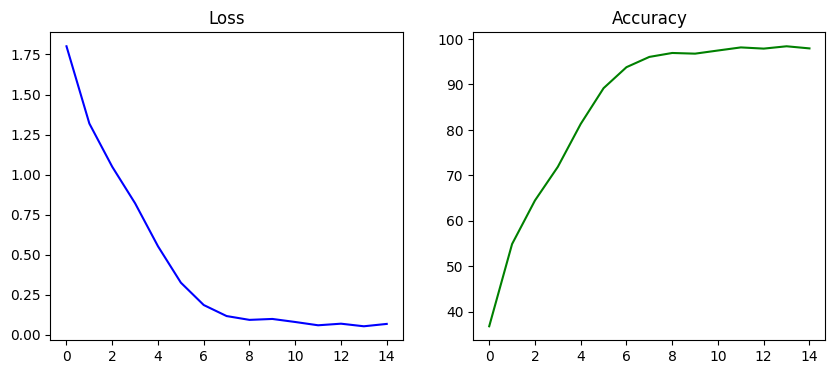

ITS DONE ! 🎉


In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1️⃣ CONFIGURATION ET DATAFRAME (Inchangé ou presque)
# ---------------------------------------------------------
dataset_path = r"/Users/ia_dev/Desktop/Work/archive/raw-img"
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", 
             "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", 
             "scoiattolo": "squirrel", "ragno": "ragno"}

data = []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        label = translate.get(folder, folder)
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                data.append([os.path.join(folder_path, file), label])

df = pd.DataFrame(data, columns=["image_path", "label"])
num_classes = len(df['label'].unique())
label_mapping = dict(enumerate(df['label'].astype('category').cat.categories))

train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# ---------------------------------------------------------

# ---------------------------------------------------------
# 1.5️⃣ CLASSES ET TRANSFORMS (Obligatoire pour que ça tourne)
# ---------------------------------------------------------
class AnimalDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        # On convertit les noms (dog, cat...) en chiffres (0, 1...)
        self.label_to_idx = {v: k for k, v in label_mapping.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = self.label_to_idx[self.df.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialisation de l'historique pour les graphiques
history = {'loss': [], 'accuracy': []}


























# 2️⃣ DATA LOADING (Ajusté : Batch Size = 32)


# ---------------------------------------------------------
BATCH_SIZE = 32 # Modifié selon ton tableau

train_loader = DataLoader(AnimalDataset(train_df, transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(AnimalDataset(test_df, transform), batch_size=BATCH_SIZE)

# ---------------------------------------------------------
# 3️⃣ MODÈLE CNN (Ajusté selon "Model 1")
# ---------------------------------------------------------
class AnimalCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 3 couches de convolution et 3 couches de maxpooling
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # Layer 1
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # Layer 2
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # Layer 3
        )
        
        # Flatten + 2 couches denses (Model 1 précise 64 neurones)
        # Après 3 maxpoolings (224 -> 112 -> 56 -> 28), la taille est 28x28
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 64), # 1ère couche dense (64 neurones)
            nn.ReLU(),
            # Dropout: No (retiré selon ton tableau)
            nn.Linear(64, num_classes)   # 2ème couche dense (sortie)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AnimalCNN(num_classes=num_classes).to(device)

# ---------------------------------------------------------
# 4️⃣ ENTRAÎNEMENT (Paramètres Model 1)
# ---------------------------------------------------------
# Optimizer: Adam | Learning rate: default (0.001) | Momentum: No
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Epochs: 15 (comme spécifié)


for epoch in range(15):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Transfert vers la 5070
        images, labels = images.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100. * correct / total
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    
    print(f"Epoch {epoch+1}/15 | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

# ---------------------------------------------------------

# 5️⃣VALIDATION LOOP (The "Real" Test)
# ---------------------------------------------------------
model.eval()  # Switch to evaluation mode (turns off Dropout)
val_correct = 0
val_total = 0

print("\n🔍 Running Validation on unseen images...")

with torch.no_grad(): # Disable gradient calculation (saves memory/time)
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_accuracy = 100 * val_correct / val_total




# 6️⃣ VISUALISATION (Remplace tes plots matplotlib)
# ---------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history['loss'], color='blue')
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history['accuracy'], color='green')
print(f"✅ Final Validation Accuracy: {val_accuracy:.2f}%")
plt.savefig('resultats_model_1.png')
plt.show()

print("ITS DONE ! 🎉")

